## Imports

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
%matplotlib inline

In [2]:
#print versions of modules
print("Numpy: " + np.__version__)
print("Pandas: " + pd.__version__)
print("Tensorflow: " + tf.__version__)
print("Science Kit Learn: " + sklearn.__version__)

Numpy: 1.19.5
Pandas: 1.1.5
Tensorflow: 2.4.1
Science Kit Learn: 0.24.1


In [3]:
#import additional modules
from statistics import mean
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Area of study

The Ansongo-Niamey basin is a catchment located in the middle region of the Niger basin between the cities of Ansongo (Mali) and Niamey (Niger). This basin was chosen as study area because it would be challenging to collect data in the upstream of the Niger basin: the upper Niger basin. Regarding that, Ansongo being the downstream of the upper delta was considered as the upstream of our study area and Niamey the outlet of the basin.

![Ansongo-Niamey map](./images/map_study_area.png)

The Ansongo-Niger basin runoff regime is affected by different types of reoccurring floods, which result from the geographic locations and characteristics of their main source areas. 

The first one is the **Guinean Flood**, which originates from the headwaters of the Niger in the Guinean highlands during the rainy season between July and November. The flood originating in the Guinean highlands experiences its peak usually around October. From here, the Niger flows into a vast wetland that covers an area and delays there for approximately three months. This upper flood arrives in the Ansongo around January, although rainfall in the Sahelian region falls at
the same time as in the Guinean highlands. 

The second one is the annual peak during the rainy season (July to November) in the Ansongo-Niamey basin called the **“Red Flood”** or “Sahelian Flood”.

Figure below illustrates well the basin’s runoff regime by distinguishing red flood from the Guinean flood.

![Hydrographs of Ansongo, Kandadji and Niamey for June 1991 to Mai 1992](./images/q_day_1991_1993_sub.png)

## Data

In [4]:
#load data
df = pd.read_csv('./model_data/model_data_interpolated.csv')
df

,Date,pr,tmax,tmin,Ansongo,Kandadji,Niamey
0,1981-06-01,0.525346,38.824417,27.352827,14.0,20.400000,5.03
1,1981-06-02,0.732719,39.789036,27.593908,13.0,17.000000,4.61
2,1981-06-03,0.341014,39.171715,26.769451,13.0,14.600000,4.14
3,1981-06-04,1.986175,39.452515,28.201244,13.0,14.100000,3.68
4,1981-06-05,0.271889,39.426506,26.821142,13.0,12.900000,2.99
...,...,...,...,...,...,...,...
10801,2010-12-27,0.000000,33.876694,19.051850,1751.0,1841.915039,1669.00
10802,2010-12-28,0.000000,33.088223,18.405252,1753.0,1851.276978,1677.00
10803,2010-12-29,0.000000,30.650715,17.136805,1752.0,1851.276978,1684.00
10804,2010-12-30,0.000000,29.456808,16.068770,1749.0,1851.276978,1684.00


In [5]:
#drop time column
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d') #or infer_datetime_format=True

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

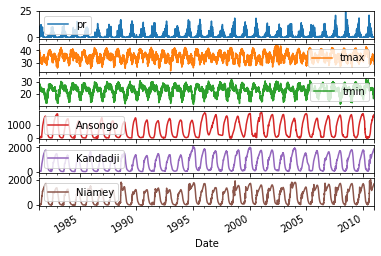

In [6]:
#view dataset
df.set_index(date_time)[['pr', 'tmax', 'tmin', 'Ansongo', 'Kandadji', 'Niamey']].plot(subplots=True)

In [7]:
#inspection
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pr,10806.0,1.375334,2.311514,0.000000e+00,0.000000,0.414747,1.824885,24.069124
tmax,10806.0,35.124774,3.299601,2.389276e+01,32.604908,35.198283,37.532277,43.912750
tmin,10806.0,22.947793,3.614374,1.133926e+01,20.857830,23.514691,25.549257,32.082210
Ansongo,10806.0,685.853843,599.710296,5.530694e-07,99.000000,538.000000,1240.750000,1904.000000
Kandadji,10806.0,695.545463,607.054939,1.120000e+00,104.000000,542.094513,1260.000000,2090.000000
Niamey,10806.0,705.412916,565.640158,0.000000e+00,116.000000,688.500000,1209.000000,1993.000000


## Normalization

The first operation is to normalize the features of the dataset. When a network is fit on unscaled data that has a range of values large inputs can slow down the learning and convergence of your network and in some cases prevent the network from effectively learning your problem. To solve this issue, it is highly recommended to normalize the dataset. Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.

In [8]:
#select values of dataframe
values = df.values

In [9]:
#rescale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Transformation

The second operation is to transform the time series into a supervised learning series. Time series forecasting problems must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences. A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values. A supervised learning problem is comprised of input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns. To do this, we used the “series_to_supervised” function of Jason Brownlee and assumed that the discharge of Ansongo and Kandadji both takes one timestep (a day) to get to Niamey.

In [10]:
#function to transform time series to supervised learning series
#This function was extracted from 
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
#using function above
reframed = series_to_supervised(scaled, 1, 1)

In [13]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7,8,9,10]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t)
1,0.021827,0.745837,0.772000,0.007353,0.009230,0.002313
2,0.030442,0.794020,0.783623,0.006828,0.007602,0.002077
3,0.014168,0.763185,0.743876,0.006828,0.006453,0.001846
4,0.082520,0.777211,0.812902,0.006828,0.006214,0.001500
5,0.011296,0.775912,0.746368,0.006828,0.005639,0.001264


## Data split

The third operation is to split the data into training, validation and training sets. 

The model is initially fit in a **training set**, which is a set of examples used to fit the parameters of the model.

Successively, the fitted model is used to predict the responses for the observations in a second dataset called the **validation dataset**. The validation dataset provides an unbiased evaluation of a model fit on the training dataset. 

The **test dataset** is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset. 

The dataset was also split into inputs and outputs. The figure below illustrates the different divisions of the dataset.

![subdivisions of dataset](./images/split_dataset.png)

In [14]:
# split into train, val and test sets
values = reframed.values

n_train_years = 7305 # days in 20 years for training
n_val_years = 9131 - n_train_years # days in 5 years for validating
n_val_sum = n_train_years + n_val_years

train = values[:n_train_years, :]
val = values[n_train_years:n_val_sum, :]
test = values[n_val_sum:, :]

In [15]:
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = val[:, :-1], val[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

To finish this transformation, the dataset was reshaped in a 3D format with the final shape of each subdivision of the dataset being: (number of samples, time steps, features).

In [16]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(7305, 1, 5) (7305,) (1826, 1, 5) (1826,) (1674, 1, 5) (1674,)


## LSTM Setting Up

A sequential model was used for this work. A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. An LSTM layer was added to the model and the number of its internal units was set using the value obtained after hyperparameter optimization. A dense layer of 1 unit was added to the LSTM units to sum up the result of the LSTM units and to set it up as output data.

In [17]:
#set LSTM neural network
model = Sequential()

Now that the model is defined we can compile it and specify its optimizer, learning rate and loss function. The process of minimizing any mathematical expression is called optimization. Optimizers are algorithms or methods used to change the attributes of the neural network such as weights, biases and learning rate to reduce the losses. The optimizer used here is the Adaptive Moment Estimation (Adam) optimizer. Adam optimization is a stochastic gradient descent method that is based on the adaptive estimation of first-order and second-order moments. According to Kingma the method is “computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters”. 

The learning rate obtained from the hyperparameter optimization process is also set here. The last step of compiling our LSTM model would be to set its loss function. Since the present work would use a large number of samples, we would not set a regularization term because the chances of overfitting the data are low. As for the data loss function, the mean square error would be chosen because larger mistakes are attributed to bigger penalties due to the squaring inside the function.

In [18]:
#build model
model.add(LSTM(units=30, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(units=1))

In [19]:
#set compiler
optimizer = Adam(lr=0.01561601307656165)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________


![lstm model](./images/lstm_model.png)

## LSTM Training

For the training phase of our LSTM, the number of epochs and the batch size obtained after hyperparameter optimization are set in the model to fit.

In [21]:
%%time
history = model.fit(x_train, y_train, epochs=500, batch_size=128, validation_data=(x_val, y_val), verbose=2, shuffle=False)

Epoch 1/500
58/58 - 5s - loss: 0.0302 - mae: 0.1174 - val_loss: 0.0109 - val_mae: 0.0845
Epoch 2/500
58/58 - 1s - loss: 0.0072 - mae: 0.0611 - val_loss: 0.0083 - val_mae: 0.0725
Epoch 3/500
58/58 - 0s - loss: 0.0058 - mae: 0.0549 - val_loss: 0.0073 - val_mae: 0.0689
Epoch 4/500
58/58 - 0s - loss: 0.0047 - mae: 0.0493 - val_loss: 0.0065 - val_mae: 0.0653
Epoch 5/500
58/58 - 0s - loss: 0.0040 - mae: 0.0445 - val_loss: 0.0059 - val_mae: 0.0612
Epoch 6/500
58/58 - 1s - loss: 0.0034 - mae: 0.0406 - val_loss: 0.0053 - val_mae: 0.0569
Epoch 7/500
58/58 - 1s - loss: 0.0031 - mae: 0.0376 - val_loss: 0.0049 - val_mae: 0.0531
Epoch 8/500
58/58 - 0s - loss: 0.0029 - mae: 0.0358 - val_loss: 0.0047 - val_mae: 0.0504
Epoch 9/500
58/58 - 0s - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0046 - val_mae: 0.0487
Epoch 10/500
58/58 - 0s - loss: 0.0028 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0476
Epoch 11/500
58/58 - 0s - loss: 0.0027 - mae: 0.0340 - val_loss: 0.0045 - val_mae: 0.0470
Epoch 12/500
58/58 

58/58 - 0s - loss: 0.0023 - mae: 0.0309 - val_loss: 0.0042 - val_mae: 0.0434
Epoch 93/500
58/58 - 0s - loss: 0.0023 - mae: 0.0309 - val_loss: 0.0042 - val_mae: 0.0433
Epoch 94/500
58/58 - 0s - loss: 0.0023 - mae: 0.0309 - val_loss: 0.0042 - val_mae: 0.0433
Epoch 95/500
58/58 - 0s - loss: 0.0023 - mae: 0.0308 - val_loss: 0.0042 - val_mae: 0.0432
Epoch 96/500
58/58 - 0s - loss: 0.0023 - mae: 0.0308 - val_loss: 0.0042 - val_mae: 0.0432
Epoch 97/500
58/58 - 0s - loss: 0.0023 - mae: 0.0308 - val_loss: 0.0042 - val_mae: 0.0431
Epoch 98/500
58/58 - 0s - loss: 0.0023 - mae: 0.0308 - val_loss: 0.0042 - val_mae: 0.0431
Epoch 99/500
58/58 - 0s - loss: 0.0023 - mae: 0.0308 - val_loss: 0.0042 - val_mae: 0.0430
Epoch 100/500
58/58 - 0s - loss: 0.0023 - mae: 0.0307 - val_loss: 0.0042 - val_mae: 0.0430
Epoch 101/500
58/58 - 0s - loss: 0.0022 - mae: 0.0307 - val_loss: 0.0042 - val_mae: 0.0430
Epoch 102/500
58/58 - 0s - loss: 0.0022 - mae: 0.0307 - val_loss: 0.0042 - val_mae: 0.0429
Epoch 103/500
58/58 

Epoch 183/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0041 - val_mae: 0.0416
Epoch 184/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 185/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 186/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 187/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 188/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 189/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 190/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 191/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 192/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416
Epoch 193/500
58/58 - 0s - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0042 - val_mae: 0.0416

58/58 - 0s - loss: 0.0021 - mae: 0.0296 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 274/500
58/58 - 0s - loss: 0.0021 - mae: 0.0296 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 275/500
58/58 - 0s - loss: 0.0021 - mae: 0.0296 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 276/500
58/58 - 0s - loss: 0.0021 - mae: 0.0296 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 277/500
58/58 - 0s - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 278/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 279/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 280/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0421
Epoch 281/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0421
Epoch 282/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0421
Epoch 283/500
58/58 - 0s - loss: 0.0020 - mae: 0.0295 - val_loss: 0.0043 - val_mae: 0.0421
Epoch 284/500

Epoch 364/500
58/58 - 0s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 365/500
58/58 - 1s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 366/500
58/58 - 0s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 367/500
58/58 - 1s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 368/500
58/58 - 1s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 369/500
58/58 - 0s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 370/500
58/58 - 0s - loss: 0.0020 - mae: 0.0284 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 371/500
58/58 - 0s - loss: 0.0020 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 372/500
58/58 - 0s - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 373/500
58/58 - 0s - loss: 0.0020 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0419
Epoch 374/500
58/58 - 0s - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0042 - val_mae: 0.0419

Epoch 455/500
58/58 - 0s - loss: 0.0019 - mae: 0.0275 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 456/500
58/58 - 0s - loss: 0.0019 - mae: 0.0275 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 457/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 458/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 459/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 460/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 461/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 462/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 463/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 464/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415
Epoch 465/500
58/58 - 0s - loss: 0.0019 - mae: 0.0274 - val_loss: 0.0041 - val_mae: 0.0415

## LSTM Evaluation

The evaluation of the model is done using the test dataset.

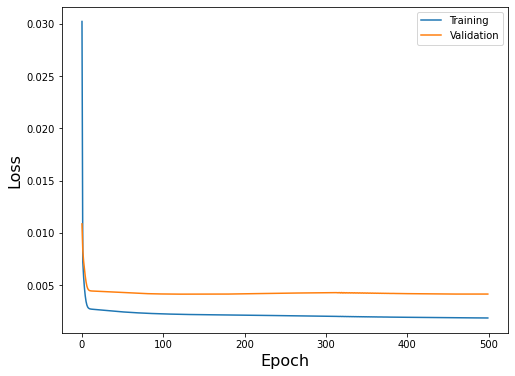

In [22]:
#plot history
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
#plt.title('LSTM Model Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
#plt.savefig('../images/evaluation_lstm.png')

The trend of the loss curve shows that the model converged reasonably quickly and both train and test performance remained equivalent. The performance and convergence behavior of the model suggest that mean squared error is a good match for a neural network learning this problem. The validation curve being above the the training curve might suggest that the model is overfitting but the very small difference between the losses means that the model does not have significant overfitting issues. Moreover, the training/validation plot implies that the model presents low bias and low variance which attests that the model has a right balance and is neither overfitting nor underfitting.

## LSTM Testing

In [23]:
# make a prediction
yhat = model.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

In [24]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, x_test), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,5]

In [25]:
# get initial values of y_test
inv_y = df['Niamey']
inv_y = inv_y[n_val_sum+1:].values

In [26]:
print(train.shape, val.shape, test.shape)

(7305, 6) (1826, 6) (1674, 6)


The next step would be to evaluate our LSTM model over the test set of data. The figure below presents the observed discharge vs the predicted discharge.

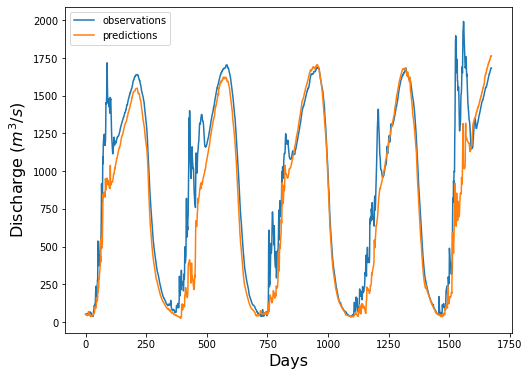

In [27]:
#plot
plt.figure(figsize=(8,6))
plt.plot(inv_y, label='observations')
plt.plot(inv_yhat, label='predictions')
#plt.title('Predicted vs Observed')
plt.xlabel('Days', fontsize=16)
plt.ylabel('Discharge ($m^3/s$)', fontsize=16)
plt.legend()
#plt.savefig('../images/prediction_vs_observation.png')

When presented with the LSTM model with a new set of data, we notice that the Guinean flood is well simulated while the red flood is not well simulated. The peaks of the red flood are underestimated by the deep learning model. This may be explained by the fact that maybe the right set of climate variables were not included in the model because the red flood originates from the climatic conditions within the Ansongo-Niamey basin.

In [28]:
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(inv_y, inv_yhat, 1)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in inv_y]

In [29]:
df = pd.DataFrame({'y':inv_y, 'yhat':inv_yhat})

In [30]:
df = df.reset_index()

In [31]:
red_flood = df[55:120].append(df[410:495]).append(df[750:850]).append(df[1175:1215]).append(df[1500:1590])

<Figure size 576x432 with 0 Axes>

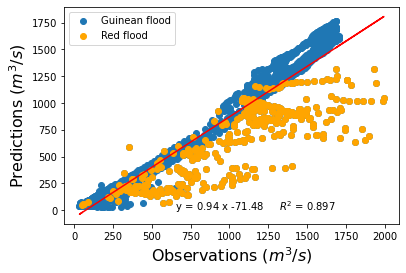

In [32]:
#plot
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
ax.scatter(inv_y,inv_yhat, color='tab:blue', label='Guinean flood')
ax.scatter(red_flood['y'], red_flood['yhat'], color='orange', label='Red flood')
plt.plot(inv_y, abline_values, 'red')
plt.xlabel('Observations ($m^3/s$)', fontsize=16)
plt.ylabel('Predictions ($m^3/s$)', fontsize=16)
plt.text(0, 0, '                                y = {} x {}     $R^2$ = 0.897'.format(round(slope, 2), round(intercept, 2)))
plt.legend()
#plt.savefig('../images/prediction_vs_observation_flood.png')

The Guinean flood is slightly overestimated while the red flood is considerably underestimated. The slope of the comparison between the observed values and the predicted ones is 0.94 and its intercept is -71.48.

In [33]:
# Calculate coefficient of determination
correlation_matrix = np.corrcoef(inv_y, inv_yhat)
correlation_xy = correlation_matrix[0,1]
R2 = correlation_xy**2
print('R2: %.3f' % R2)

R2: 0.897


In [34]:
# Calculate Nash-Sutcliffe model efficiency coefficient 
nse = 1 - ( sum((inv_y - inv_yhat) ** 2 ) / sum( (inv_y - mean(inv_y)) ** 2) ) 
print('NSE: %.3f' % nse)

NSE: 0.852


In [35]:
# calculate RMSE
rmse = sqrt(1/len(inv_y)* sum((inv_y - inv_yhat) ** 2 ))
print('RMSE: %.3f' % rmse)

RMSE: 229.158


The R2, NSE and RMSE calculated were respectively 0.897, 0.852 and 229.158. This confirms the fact that the LSTM model is overall good at simulating discharge in general and particularly at the outlet of the Ansongo-Niamey basin.